# Real-time benchmarking for qubit selection
*Usage estimate: 4 minutes on ibm_brisbane (NOTE: This is an estimate only. Your runtime might vary.)*

In [1]:
# This cell is hidden from users – it disables some lint rules
# ruff: noqa: E722

## Background
This tutorial shows how to run real-time characterization experiments and update backend properties to improve qubit selection when mapping a circuit to the physical qubits on a QPU. You will learn the basic characterization experiments that are used to determine properties of the QPU, how to do them in Qiskit, and how to update the properties saved in the backend object representing the QPU based on these experiments.

The QPU-reported properties are updated once a day, but the system may drift faster than the time between updates. This can affect the reliability of the qubit selection routines in the `Layout` stage of the pass manager, as they'd be using reported properties that don't represent the present state of the QPU. For this reason, it may be worth devoting some QPU time to characterization experiments, which can then be used to update the QPU properties used by the `Layout` routine.

## Requirements
Before starting this tutorial, be sure you have the following installed:

- Qiskit SDK v1.0 or later, with visualization support ( `pip install 'qiskit[visualization]'` )
- Qiskit Runtime 0.29 or later ( `pip install qiskit-ibm-runtime` )
- Qiskit Experiments 0.7 or later ( `pip install qiskit-experiments` )

## Setup

In [2]:
from qiskit_ibm_runtime import SamplerV2
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.quantum_info import hellinger_fidelity
from qiskit.transpiler import InstructionProperties


from qiskit_experiments.library import (
    T1,
    T2Hahn,
    LocalReadoutError,
    StandardRB,
)
from qiskit_experiments.framework import BatchExperiment, ParallelExperiment

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session

from datetime import datetime
from collections import defaultdict
import numpy as np
import rustworkx
import matplotlib.pyplot as plt
import copy

## Step 1: Map classical inputs to a quantum problem

To benchmark the difference in performance, we consider a circuit that prepares a Bell state across a linear chain of varying length. The fidelity of the Bell state at the ends of the chain is measured.

### Setting up backend and coupling map

In [3]:
service = QiskitRuntimeService(
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/26b15df5f5684154b2c791c32e07e69b:08dcfec2-410b-45a4-8185-10fd26ce26f6::"
)

# To run on hardware, select a backend that supports the ecr gate
service.backends(filters=lambda x: ("ecr" in x.basis_gates))

[<IBMBackend('ibm_brisbane')>]

In [4]:
backend = service.backend("ibm_brisbane")

qubits = list(range(backend.num_qubits))

In [5]:
coupling_graph = backend.coupling_map.graph.to_undirected(multigraph=False)

# Get unidirectional coupling map
one_dir_coupling_map = coupling_graph.edge_list()

# Get layered coupling map
edge_coloring = rustworkx.graph_bipartite_edge_color(coupling_graph)
layered_coupling_map = defaultdict(list)
for edge_idx, color in edge_coloring.items():
    layered_coupling_map[color].append(
        coupling_graph.get_edge_endpoints_by_index(edge_idx)
    )
layered_coupling_map = [
    sorted(layered_coupling_map[i])
    for i in sorted(layered_coupling_map.keys())
]

flattened_layered_coupling_map = []
for layer in layered_coupling_map:
    flattened_layered_coupling_map += layer

### Characterization experiments

A series of experiments is used to characterize the main properties of the qubits in a QPU. These are $T_1$, $T_2$, readout error, and single-qubit and two-qubit gate error. We'll briefly summarize what these properties are and refer to experiments in the [`qiskit-experiments`](https://qiskit-community.github.io/qiskit-experiments/index.html) package that are used to characterize them.

#### T1
$T_1$ is the characteristic time it takes for an excited qubit to fall to the ground state due to amplitude-damping decoherence processes. In a [$T_1$ experiment](https://qiskit-community.github.io/qiskit-experiments/manuals/characterization/t1.html), we measure an excited qubit after a delay. The larger the delay time is, the more
likely is the qubit to fall to the ground state. The goal of the
experiment is to characterize the decay rate of the qubit towards the
ground state.

#### T2
$T_2$ represents the amount of time required for a single qubit's Bloch
vector projection on the XY plane to fall to approximately 37% ($\frac{1}{e}$) of
its initial amplitude due to dephasing decoherence processes. In a [$T_2$ Hahn Echo experiment](https://qiskit-community.github.io/qiskit-experiments/manuals/characterization/t2hahn.html), we can estimate the rate of this decay.

#### State preparation and measurement (SPAM) error characterization
In a [SPAM-error characterization experiment](https://qiskit-community.github.io/qiskit-experiments/manuals/measurement/readout_mitigation.html) qubit are prepared in a certain state ($\vert 0 \rangle$ or $\vert 1 \rangle$) and measured. The probability of measuring a state different than the one prepared then gives the probability of the error.

#### Single-qubit and two-qubit randomized benchmarking
[Randomized benchmarking](https://qiskit-community.github.io/qiskit-experiments/manuals/verification/randomized_benchmarking.html) is a popular protocol for characterizing the error rate of
quantum processors. An RB experiment consists of the generation of random Clifford
circuits on the given qubits such that the unitary computed by the circuits is the
identity. After running the circuits, the number of shots resulting in an error (that is, an output different from the ground state) are counted, and from this data one can infer error estimates for the quantum device, by calculating the Error Per Clifford.

In [6]:
# Create T1 experiments on all qubit in parallel
t1_exp = ParallelExperiment(
    [
        T1(
            physical_qubits=[qubit],
            delays=np.linspace(
                1e-6, 2 * backend.properties().t1(qubit), 5, endpoint=True
            ),
        )
        for qubit in qubits
    ],
    backend,
    analysis=None,
)

# Create T2-Hahn experiments on all qubit in parallel
t2_exp = ParallelExperiment(
    [
        T2Hahn(
            physical_qubits=[qubit],
            delays=np.linspace(
                1e-6, 2 * backend.properties().t2(qubit), 5, endpoint=True
            ),
        )
        for qubit in qubits
    ],
    backend,
    analysis=None,
)

# Create readout experiments on all qubit in parallel
readout_exp = LocalReadoutError(qubits)

# Create single-qubit RB experiments on all qubit in parallel
singleq_rb_exp = ParallelExperiment(
    [
        StandardRB(
            physical_qubits=[qubit], lengths=[10, 100, 500], num_samples=10
        )
        for qubit in qubits
    ],
    backend,
    analysis=None,
)

# Create two-qubit RB experiments on the three layers of disjoint edges of the heavy-hex
twoq_rb_exp_batched = BatchExperiment(
    [
        ParallelExperiment(
            [
                StandardRB(
                    physical_qubits=pair,
                    lengths=[10, 50, 100],
                    num_samples=10,
                )
                for pair in layer
            ],
            backend,
            analysis=None,
        )
        for layer in layered_coupling_map
    ],
    backend,
    flatten_results=True,
    analysis=None,
)

### QPU properties over time
Looking at the reported QPU properties over time (we'll consider a single week below), we see how these can fluctuate on a scale of a single day. Small fluctuations can happen even within a day. In this scenario, the reported properties (updated once per day) will not accurately capture the current status of the QPU. Moreover, if a job is transpiled locally (using current reported properties) and submitted but executed only at a later time (minutes or days), it may run the risk of having used outdated properties for qubit selection in the transpilation step. This highlights the importance of having updated information about the QPU at execution time. First, let's retrieve the properties over a certain time range.

In [7]:
errors_list = []
for day_idx in range(10, 17):
    calibrations_time = datetime(
        year=2024, month=10, day=day_idx, hour=0, minute=0, second=0
    )
    targer_hist = backend.target_history(datetime=calibrations_time)

    t1_dict, t2_dict = {}, {}
    for qubit in range(targer_hist.num_qubits):
        t1_dict[qubit] = targer_hist.qubit_properties[qubit].t1
        t2_dict[qubit] = targer_hist.qubit_properties[qubit].t2

    errors_dict = {
        "1q": targer_hist["sx"],
        "2q": targer_hist["ecr"],
        "spam": targer_hist["measure"],
        "t1": t1_dict,
        "t2": t2_dict,
    }

    errors_list.append(errors_dict)

Then, let's plot the values

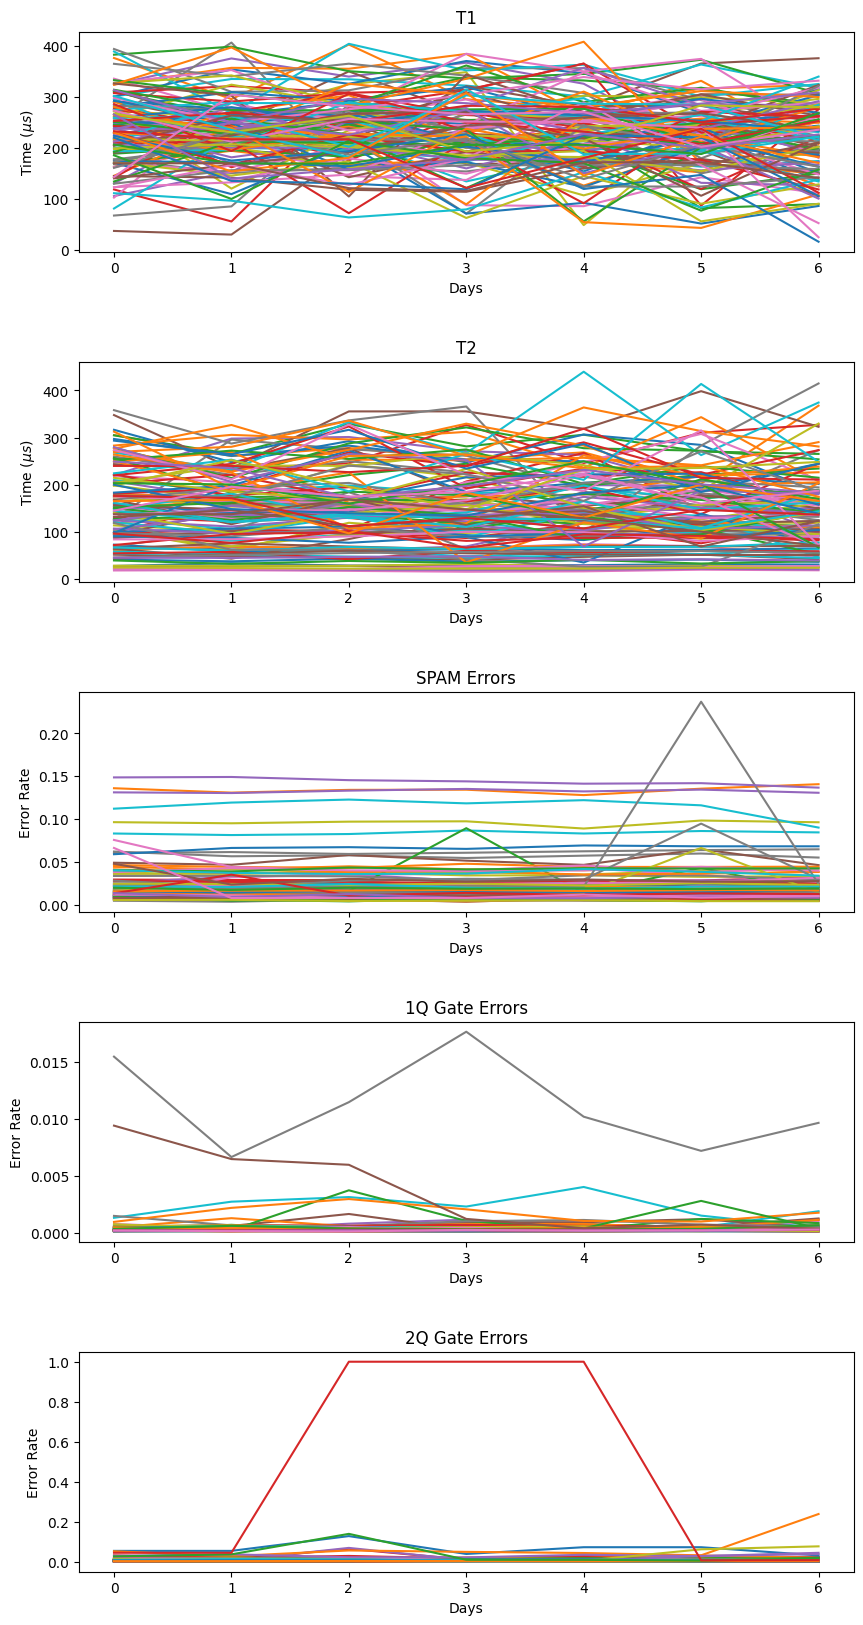

In [8]:
fig, axs = plt.subplots(5, 1, figsize=(10, 20), sharex=False)


# Plot for T1 values
for qubit in range(targer_hist.num_qubits):
    t1s = []
    for errors_dict in errors_list:
        t1_dict = errors_dict["t1"]
        t1s.append(t1_dict[qubit] / 1e-6)

    axs[0].plot(t1s)

axs[0].set_title("T1")
axs[0].set_ylabel(r"Time ($\mu s$)")
axs[0].set_xlabel("Days")

# Plot for T2 values
for qubit in range(targer_hist.num_qubits):
    t2s = []
    for errors_dict in errors_list:
        t2_dict = errors_dict["t2"]
        t2s.append(t2_dict[qubit] / 1e-6)

    axs[1].plot(t2s)

axs[1].set_title("T2")
axs[1].set_ylabel(r"Time ($\mu s$)")
axs[1].set_xlabel("Days")

# Plot SPAM values
for qubit in range(targer_hist.num_qubits):
    spams = []
    for errors_dict in errors_list:
        spam_dict = errors_dict["spam"]
        spams.append(spam_dict[tuple([qubit])].error)

    axs[2].plot(spams)

axs[2].set_title("SPAM Errors")
axs[2].set_ylabel("Error Rate")
axs[2].set_xlabel("Days")

# Plot 1Q Gate Errors
for qubit in range(targer_hist.num_qubits):
    oneq_gates = []
    for errors_dict in errors_list:
        oneq_gate_dict = errors_dict["1q"]
        oneq_gates.append(oneq_gate_dict[tuple([qubit])].error)

    axs[3].plot(oneq_gates)

axs[3].set_title("1Q Gate Errors")
axs[3].set_ylabel("Error Rate")
axs[3].set_xlabel("Days")

# Plot 2Q Gate Errors
for pair in one_dir_coupling_map:
    twoq_gates = []
    for errors_dict in errors_list:
        twoq_gate_dict = errors_dict["2q"]
        twoq_gates.append(twoq_gate_dict[pair].error)

    axs[4].plot(twoq_gates)

axs[4].set_title("2Q Gate Errors")
axs[4].set_ylabel("Error Rate")
axs[4].set_xlabel("Days")

plt.subplots_adjust(hspace=0.5)
plt.show()

You can see that over several days some of the qubit properties can change considerably. This highlights the importance of having fresh information of the QPU status, to be able to select the best performing qubits for an experiment.

In [9]:
from qiskit import QuantumCircuit

ideal_dist = {"00": 0.5, "11": 0.5}

num_qubits_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 127]
circuits = []
for num_qubits in num_qubits_list:
    circuit = QuantumCircuit(num_qubits, 2)
    circuit.h(0)
    for i in range(num_qubits - 1):
        circuit.cx(i, i + 1)
    circuit.barrier()
    circuit.measure(0, 0)
    circuit.measure(num_qubits - 1, 1)
    circuits.append(circuit)

circuits[-1].draw(output="mpl", style="clifford", fold=-1)

## Step 2: Optimize problem for quantum hardware execution
No optimization of the circuits or operators is done in this tutorial.

## Step 3: Execute using Qiskit primitives

###  Execute a quantum circuit with default qubit selection
As a reference result of performance, we'll execute a quantum circuit on a QPU by using the default qubits, which are the qubits selected with the requested backend properties. We will use `optimization_level = 3`.  This setting includes the most advanced transpilation optimization, and uses target properties (like operation errors) to select the best performing qubits for execution.

In [10]:
pm = generate_preset_pass_manager(target=backend.target, optimization_level=3)
isa_circuits = pm.run(circuits)
initial_qubits = [
    [
        idx
        for idx, qb in circuit.layout.initial_layout.get_physical_bits().items()
        if qb._register.name != "ancilla"
    ]
    for circuit in isa_circuits
]

### Execute a quantum circuit with real-time qubit selection

In this section, we'll investigate the importance of having updated information on qubit properties of the QPU for optimal results. First, we'll carry out a full suite of QPU characterization experiments ($T_1$, $T_2$, SPAM, single-qubit RB and two-qubit RB), which we can then use to update the backend properties. This allows the pass manager to select qubits for the execution based on fresh information about the QPU, possibly improving execution performances. Second, we execute the Bell pair circuit and we compare the fidelity obtained after selecting the qubits with update QPU properties to the fidelity we obtained before when we use the default reported properties for qubit selection.

In [12]:
# Prepare characterization experiments
batches = [t1_exp, t2_exp, readout_exp, singleq_rb_exp, twoq_rb_exp_batched]
batches_exp = BatchExperiment(batches, backend)  # , analysis=None)
run_options = {"shots": 1e3, "dynamic": False}

with Session(backend=backend) as session:
    sampler = SamplerV2(mode=session)

    # Run characterization experiments
    batches_exp_data = batches_exp.run(
        sampler=sampler, **run_options
    ).block_for_results()

    EPG_sx_result_list = batches_exp_data.analysis_results("EPG_sx")
    EPG_sx_result_q_indices = [
        result.device_components.index for result in EPG_sx_result_list
    ]
    EPG_x_result_list = batches_exp_data.analysis_results("EPG_x")
    EPG_x_result_q_indices = [
        result.device_components.index for result in EPG_x_result_list
    ]
    T1_result_list = batches_exp_data.analysis_results("T1")
    T1_result_q_indices = [
        result.device_components.index for result in T1_result_list
    ]

    T2_result_list = batches_exp_data.analysis_results("T2")
    T2_result_q_indices = [
        result.device_components.index for result in T2_result_list
    ]

    Readout_result_list = batches_exp_data.analysis_results(
        "Local Readout Mitigator"
    )

    EPG_ecr_result_list = batches_exp_data.analysis_results("EPG_ecr")

    # Update target properties
    target = copy.deepcopy(backend.target)
    for i in range(target.num_qubits - 1):
        qarg = (i,)

        if qarg in EPG_sx_result_q_indices:
            target.update_instruction_properties(
                instruction="sx",
                qargs=qarg,
                properties=InstructionProperties(
                    error=EPG_sx_result_list[i].value.nominal_value
                ),
            )
        if qarg in EPG_x_result_q_indices:
            target.update_instruction_properties(
                instruction="x",
                qargs=qarg,
                properties=InstructionProperties(
                    error=EPG_x_result_list[i].value.nominal_value
                ),
            )

        err_mat = Readout_result_list.value.assignment_matrix(i)
        readout_assignment_error = (
            err_mat[0, 1] + err_mat[1, 0]
        ) / 2  # average readout error
        target.update_instruction_properties(
            instruction="measure",
            qargs=qarg,
            properties=InstructionProperties(error=readout_assignment_error),
        )

        if qarg in T1_result_q_indices:
            target.qubit_properties[i].t1 = T1_result_list[
                i
            ].value.nominal_value
        if qarg in T2_result_q_indices:
            target.qubit_properties[i].t2 = T2_result_list[
                i
            ].value.nominal_value

    for pair_idx, pair in enumerate(flattened_layered_coupling_map):
        qarg = tuple(pair)
        try:
            target.update_instruction_properties(
                instruction="ecr",
                qargs=qarg,
                properties=InstructionProperties(
                    error=EPG_ecr_result_list[pair_idx].value.nominal_value
                ),
            )
        except:
            target.update_instruction_properties(
                instruction="ecr",
                qargs=qarg[::-1],
                properties=InstructionProperties(
                    error=EPG_ecr_result_list[pair_idx].value.nominal_value
                ),
            )

    # transpile circuits to updated target
    pm = generate_preset_pass_manager(target=target, optimization_level=3)
    isa_circuit_updated = pm.run(circuits)
    updated_qubits = [
        [
            idx
            for idx, qb in circuit.layout.initial_layout.get_physical_bits().items()
            if qb._register.name != "ancilla"
        ]
        for circuit in isa_circuit_updated
    ]

    n_trials = 3  # run multiple trials to see variations

    # interleave circuits
    interleaved_circuits = []
    for original_circuit, updated_circuit in zip(
        isa_circuits, isa_circuit_updated
    ):
        interleaved_circuits.append(original_circuit)
        interleaved_circuits.append(updated_circuit)

    # Run circuits
    # Set simple error suppression/mitigation options
    sampler.options.dynamical_decoupling.enable = True
    sampler.options.dynamical_decoupling.sequence_type = "XY4"

    job_interleaved = sampler.run(interleaved_circuits * n_trials)

RequestsApiError: "('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))"

## Step 4: Post-process and return result in desired classical format

Finally, let's compare the fidelity of the Bell state obtained in the two different settings:
- `original`, that is with the default qubits chosen by the transpiler based on reported properties of the backend.
- `updated`, that is with the qubits chosen based on updated properties of the backend after characterization experiments have run.

In [ ]:
results = job_interleaved.result()
all_fidelity_list, all_fidelity_updated_list = [], []
for exp_idx in range(n_trials):
    fidelity_list, fidelity_updated_list = [], []

    for idx, num_qubits in enumerate(num_qubits_list):
        pub_result_original = results[
            2 * exp_idx * len(num_qubits_list) + 2 * idx
        ]
        pub_result_updated = results[
            2 * exp_idx * len(num_qubits_list) + 2 * idx + 1
        ]

        fid = hellinger_fidelity(
            ideal_dist, pub_result_original.data.c.get_counts()
        )
        fidelity_list.append(fid)

        fid_up = hellinger_fidelity(
            ideal_dist, pub_result_updated.data.c.get_counts()
        )
        fidelity_updated_list.append(fid_up)
    all_fidelity_list.append(fidelity_list)
    all_fidelity_updated_list.append(fidelity_updated_list)

In [ ]:
plt.figure(figsize=(8, 6))
plt.errorbar(
    num_qubits_list,
    np.mean(all_fidelity_list, axis=0),
    yerr=np.std(all_fidelity_list, axis=0),
    fmt="o-.",
    label="original",
    color="b",
)
# plt.plot(num_qubits_list, fidelity_list, '-.')
plt.errorbar(
    num_qubits_list,
    np.mean(all_fidelity_updated_list, axis=0),
    yerr=np.std(all_fidelity_updated_list, axis=0),
    fmt="o-.",
    label="updated",
    color="r",
)
# plt.plot(num_qubits_list, fidelity_updated_list, '-.')
plt.xlabel("Chain length")
plt.xticks(num_qubits_list)
plt.ylabel("Fidelity")
plt.title("Bell pair fidelity at the edge of N-qubits chain")
plt.legend()
plt.grid(
    alpha=0.2,
    linestyle="-.",
)
plt.show()

With increasing chain length, and thus less freedom to choose physical qubits, the fact that we have updated information about qubit properties becomes less substantial, with there being no difference when all of the qubits are used.

<div class="alert alert-block alert-success">
<b>Call to Action:</b> Try to apply this method to your executions and determine how much of a benefit you get! You can also try and see how much improvements you get from different backends.
</div>

## Tutorial survey

Please take this short survey to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_0w6FZ9QrWkKfTQq)